# Analysis of the Heat Capacity of an Unknown Substance Using the Debye and Quantum Free Electron Models

## Introduction
The rate at which the internal energy of a substance changes with increasing temperature is called its heat capacity. More formally, the molar heat capacity $C_v$ is defined with the following,

$
\begin{equation}
\displaystyle C_v = \frac{\partial E}{\partial T}
\end{equation}
$

where E is the internal energy of a mol of the substance, and T is its temperature. To calculate the heat capacity, we need to model how the energy of the components of the substance depends on temperature. In the case of metals, the primary contributors to the heat capacity are the metal's lattice and electrons, and their temperature energy dependence can be approximated with the Debye model and the quantum free electron model, respectively.

The heat capacity in the quantum free electron model is given by:

$
\begin{equation}
\displaystyle C_v = \int_0^{\infty} E\ g(E)\ \frac{\partial f(E)}{\partial T}\ dE
\end{equation}
$

where $E$ is the free-electron energy, $g(E)$ is the density of states, and $f(E)$ is the Fermi-Dirac distribution. For the debye model, the molar heat capacity is given by:

$
\begin{equation}
\displaystyle C_v = 9 N_a k_b \Big(\frac{T}{\Theta_D}\Big)^3 \int_0^{\Theta_D/T} \frac{x^4e^x}{(e^x - 1)^2} dx
\end{equation}
$

where $x = \hbar\omega/k_bT$ and $\Theta_D = \hbar\omega_D/k_b$. Both of the above integrals cannot be solved analytically—numerical integration is required to obtain the heat capacity.

In this paper, we use the models described above to determine the theoretical heat capacity of an unknown substance and compare it to experimental data. However, before computing the theoretical heat capacity of the substance, we determine its Fermi energy and Debye temperature using the experimental heat capacity data. Python is used to perform this analysis, and we start by importing all required libraries:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.constants as const
import scipy.integrate as integrate
import IPython.display as disp
plt.style.use('fivethirtyeight')

## Analyze Heat Capacity Data From an Unknown Substance
The heat capacity data for our unknown substance is stored in the file `heat_capacity.csv`. We first import this data using pandas and rename the columns for more convienient indexing:

In [2]:
data = pd.read_csv('heat_capacity.csv')
disp.display(data.head())
data.columns = ['temp', 'cv']

,temperature (K),heat capacity (J mol^-1 K^-1)
0,1.00,0.00074
1,1.76,0.00147
2,1.87,0.00159
3,2.00,0.00177
4,2.16,0.00198


We plot the data to get a sense of what it looks like,

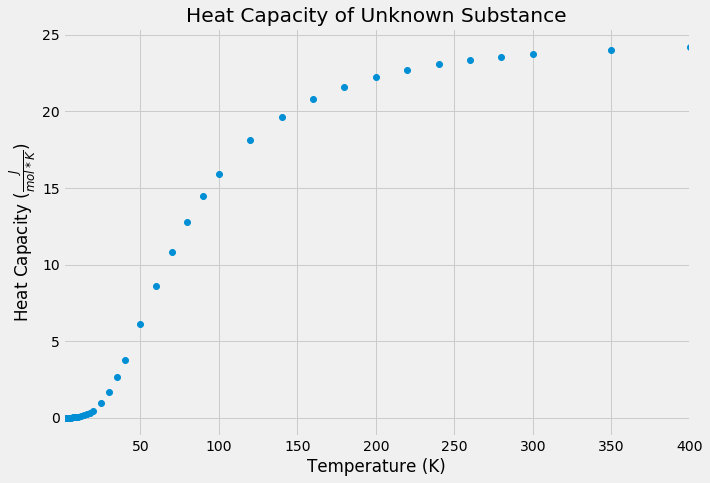

In [3]:
data.plot(x='temp', y='cv', title='Heat Capacity of Unknown Substance', legend=False, style='o', figsize=(10, 7))
plt.xlabel('Temperature (K)')
plt.ylabel('Heat Capacity ($\\frac{J}{mol * K}$)')

In order to compute the theoretical heat capacity of this substance using the Debye and quantum free electron models, we need to determine two of its physical constants, the Fermi energy, $E_f$ and the Debye temperature, $\Theta_D$. This is accomplished by taking the low temperature limits of equations (2) and (3).

For the quatum free electron model, the heat capacity at low temperature can be approximated with [1],

$
\begin{equation}
\displaystyle C_v = \frac{\pi^2}{2}\frac{N}{E_f}k_b^2T
\end{equation}
$

where $N$ is the number of condution electrons. Similarly, we can model the Debye heat capacity at low temperature with [1],

$
\begin{equation}
\displaystyle C_v = \frac{12\pi^4}{5}N_ak_b\Big(\frac{T}{\Theta_D}\Big)^3
\end{equation}
$

Since we expect the substance's heat capacity the be the sum of the electronic and lattice heat capacities, we can find a replationship for the total heat capacity,

$
\begin{equation}
\displaystyle \frac{C_v}{T} = \Big[\frac{\pi^2}{2}\frac{N_a}{E_f}k_b^2T\Big] + \Big[\frac{12\pi^4}{5\Theta_D^3}N_ak_b\ T^2 \Big]
\end{equation}
$

Using the above relationship, we can fit a line to $\frac{C_v}{T}$ versus $T^2$ to find the Debye temperature and Fermi energy of the substance. For this analysis, we use the data that is below 5 K so that the temperature is sufficiently low for the approximations:

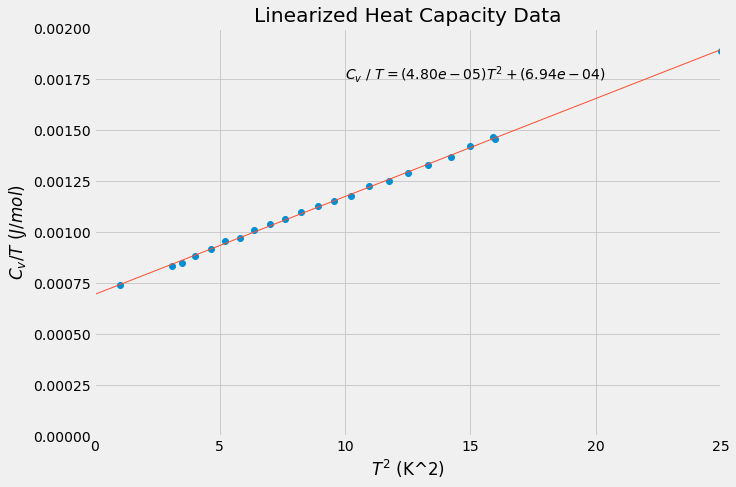

In [4]:
MAX_TEMP = 5 # Kelvin

data['temp_sq'] = data['temp']**2
data['cv/temp'] = data['cv'] / data['temp']

# Fit a line to the low temp data
low_t = data.loc[data['temp'] < MAX_TEMP]
slope, intc = np.polyfit(low_t['temp_sq'], low_t['cv/temp'], 1)

# Plot the data and the fit line
data.plot(x='temp_sq', y='cv/temp', xlim=(0, MAX_TEMP**2), ylim=(0, 0.002),
          title='Linearized Heat Capacity Data', legend=False, figsize=(10, 7), style='o')
x = np.linspace(0, MAX_TEMP**2)
plt.plot(x, slope*x + intc, linewidth=1)
plt.xlabel('$T^2$ (K^2)')
plt.ylabel('$C_v/T$ ($J/mol$)')
plt.gca().text(10, 0.00175, '$C_v\ /\ T = ({:.2e})T^2 + ({:.2e})$'.format(slope, intc))

We can now use equation (6) with the slope and intercept of the fit line to find the Fermi energy and the Debye temperature:

In [16]:
NUM_ELEC = const.Avogadro
fermi_energy = const.pi**2 * NUM_ELEC * const.Boltzmann**2 / (2 * intc)
debye_temp = (12 * const.pi**4 * const.Avogadro * const.Boltzmann / (5 * slope))**(1/3)

disp.display(disp.Latex('Debye Temp = $\Theta_D = {:.1f}$ K'.format(debye_temp)))
disp.display(disp.Latex('Fermi Temp = $\Theta_D = {:.2e}$ K'.format(fermi_energy / (const.Boltzmann))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Computing the QFEM Contribution to the Heat Capacity

With the Debye temperature and Fermi energy in hand, we can move to numerically integrating the two heat capacity equations. We start with the electron contribution to the heat capcity. Using the desnity of states for 3D in equation (2), we obtain,

$
\begin{equation}
\displaystyle C_v = \int_0^\infty \frac{3N}{2E_f^{3/2}}E^{3/2}\ \frac{\partial f(E, T)}{\partial T} dE
\end{equation}
$

where,

$
\begin{equation}
\displaystyle \frac{\partial f(E, T)}{\partial T} = \frac{E - E_f}{k_bT^2}\frac{e^{(E-Ef)/k_bT}}{(e^{(E-Ef)/k_bT} + 1)^2}
\end{equation}
$

Combining these equations and substituting $x = \frac{E}{k_bT}$ and $C = \frac{E_f}{k_bT}$, we obtain,

$
\begin{equation}
\displaystyle C_v = \frac{Nk_b^{5/2}}{E_f^{3/2}} T^{3/2} \int_0^\infty x^{3/2} (x-C)\frac{e^{x-C}}{(e^{x-C} + 1)^2}dx
\end{equation}
$

We can define a function for the integrand of this equation to enable numerical integration:

In [6]:
def qfem_integrand(x, C):
    p = x - C
    # Hack to prevent buffer overflows. If p is greater than 709
    # the integrand is effectively zero.
    v = 0 if (p > 709) else np.exp(p) / (np.exp(p) + 1)**2
    return x**(3/2) * p * v

This quantity needs to be integrated from $x=0$ to $x=\infty$ for every value of T we're interested in. However, we can ignore most $x$ values since the integrand is effectively zero outside $C-20 < x < C+20$. Thus we narrow the numerical integration window to this region.

We define two functions, one that computes the heat capacity for a single temperature by numerically integrating, and one that computes the heat capacity for an array of temperatures:

In [7]:
def single_electron_heat_capacity(T, Ef, radius=20):
    C = Ef / (const.Boltzmann * T)
    
    # Define bounds of integration
    upper = C + radius
    lower = C - radius if C - radius > 0 else 0
    
    cv,_ = integrate.quad(qfem_integrand, lower, upper, args=(C))
    return (NUM_ELEC * const.Boltzmann**(5/2) / (Ef**(3/2))) * T**(3/2) * cv

def electron_heat_capacity(T, Ef):
    cvs = np.zeros_like(T)
    for i,t in np.ndenumerate(T):
        cvs[i] = single_electron_heat_capacity(t, Ef)
    return cvs

We use the latter function to plot the heat capacity from $T = 1$ K to $T = 400$ K. If you feel so inclined, modify the `FERMI_ENERGY` variable to see how it changes the plot:

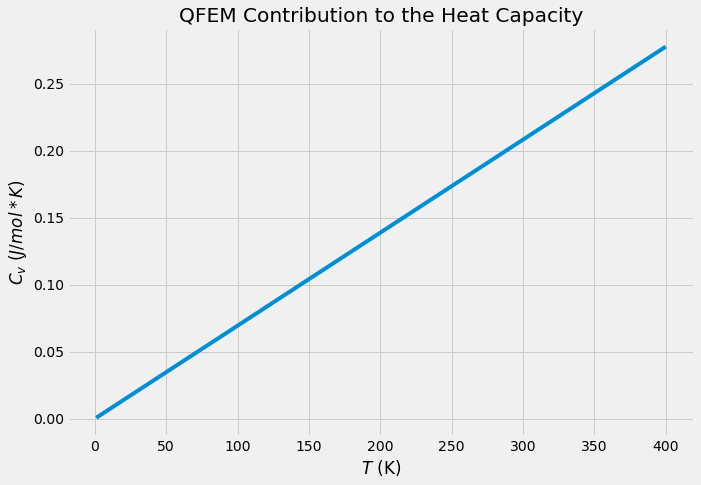

In [8]:
FERMI_ENERGY = fermi_energy
temps = np.linspace(1, 400, 1000, dtype='float64')

# Compute the heat capacity for the electrons in the solid
electron_cv = electron_heat_capacity(temps, FERMI_ENERGY)
plt.figure(figsize = (10, 7))
plt.plot(temps, electron_cv)
plt.title('QFEM Contribution to the Heat Capacity')
plt.xlabel('$T$ (K)')
plt.ylabel('$C_v$ ($J/mol * K$)')

We can calcuate at what percentage of the Fermi temperature the low temperature approximation becomes invalid (error of greater than 1%):

In [9]:
fermi_temp = FERMI_ENERGY / const.Boltzmann
T = np.linspace(1, 2*fermi_temp, 1000)
approx = intc * T
integrated = electron_heat_capacity(T, FERMI_ENERGY)

i = np.nonzero(np.abs(approx - integrated) / integrated > 0.01)
print("Percent of Fermi Temp = " + str(100 * T[i[0][0]] / (FERMI_ENERGY/const.Boltzmann)))

Percent of Fermi Temp = 12.413999181


## Computing the Debye Model Contribution to the Heat Capacity

Similarly, for the Debye model we need to numerically integrate,

$
\begin{equation}
\displaystyle Cv = 9 N_a k_b \Big(\frac{T}{\Theta_D}\Big)^3 \int_0^{\Theta_D/T} \frac{x^4e^x}{(e^x - 1)^2} dx
\end{equation}
$

Just as before, we define a function for the integrand:

In [10]:
def debye_integrand(x, T, T_debye):
    return x**4 * np.exp(x) / (np.exp(x) - 1)**2

And we create functions to numerically evaluate this integral for every temperature value we're interested in:

In [11]:
def single_debye_heat_capacity(T, T_debye):
    cv,_ = integrate.quad(debye_integrand, 0, T_debye / T, args=(T, T_debye))
    cv *= (9 * const.Avogadro * const.Boltzmann * T**3 / T_debye**3)
    return cv

def debye_heat_capacity(T, T_debye):
    cvs = np.zeros_like(T)
    for i,t in np.ndenumerate(T):
        cvs[i] = single_debye_heat_capacity(t, T_debye)
    return cvs

And we plot the Debye heat capacity in the same manner. Again, feel free to modify the `DEBYE_TEMP` variable to change the result:

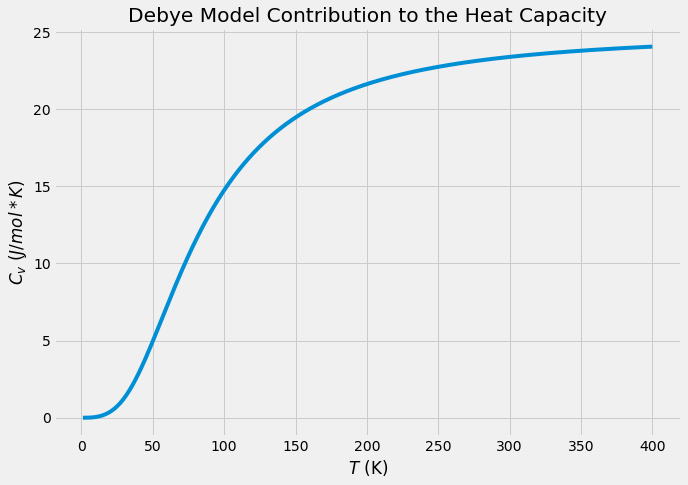

In [12]:
DEBYE_TEMP = debye_temp

# Compute the lattice contribution to the heat capacity
debye_cv = debye_heat_capacity(temps, DEBYE_TEMP)

plt.figure(figsize = (10, 7))
plt.plot(temps, debye_cv)
plt.title('Debye Model Contribution to the Heat Capacity')
plt.xlabel('$T$ (K)')
plt.ylabel('$C_v$ ($J/mol * K$)')

We can calcuate at what percentage of the Debye temperature the low temperature approximation becomes invalid (error of greater than 1%):

In [13]:
T = np.linspace(1, 2*DEBYE_TEMP, 1000)
approx = intc * T
integrated = debye_heat_capacity(T, DEBYE_TEMP)

i = np.nonzero(np.abs(approx - integrated) / integrated > 0.01)
print("Percent of Debye Temp = " + str(100 * T[i[0][0]] / (DEBYE_TEMP)))

Percent of Debye Temp = 0.291190562288


## Compare Model to Experiment
Finally, we can all the results of the two models and plot it alongside the experimental data:

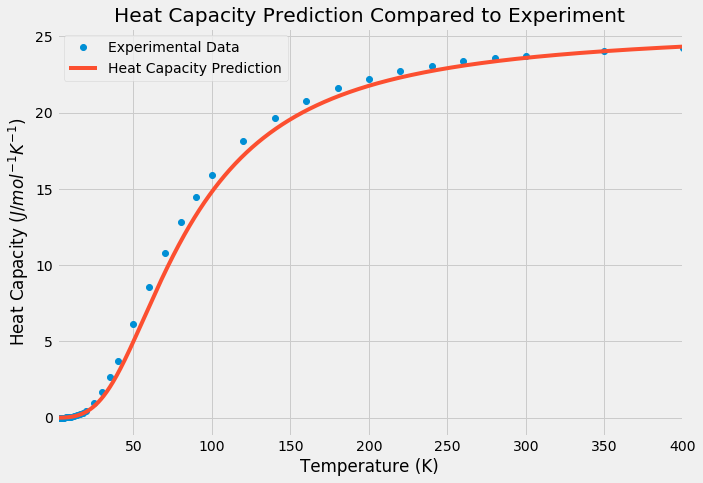

In [14]:
data.plot(x = 'temp', y='cv', style='o', figsize=(10,7))
plt.plot(temps, debye_cv + electron_cv)
plt.title('Heat Capacity Prediction Compared to Experiment')
plt.xlabel('Temperature (K)')
plt.ylabel('Heat Capacity ($J/mol^{-1} K^{-1}$)')
plt.legend(['Experimental Data', 'Heat Capacity Prediction']);

As you can see, there is good agreement between our prediction and the experimental result. It is interesting to look at the accuracy of our prediction at low temperature, where the behavior of the solid is far from classical:

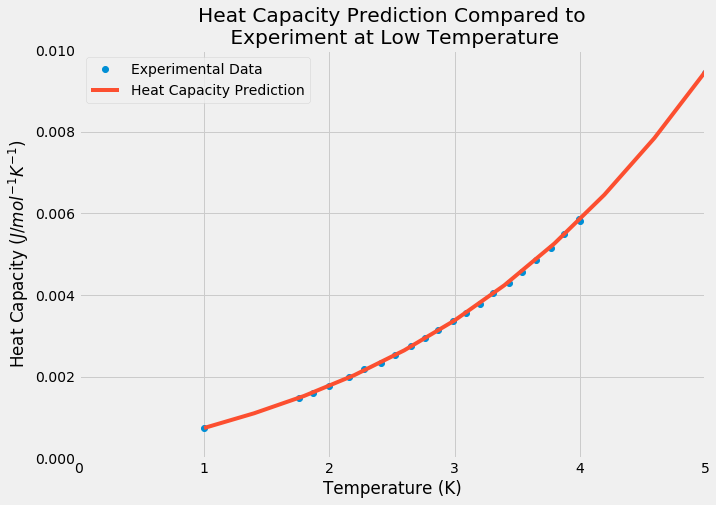

In [15]:
data.plot(x = 'temp', y='cv', style='o', figsize=(10,7), legend=False)
plt.plot(temps, debye_cv + electron_cv)
plt.axis([0, 5, -0, 0.01])
plt.title('Heat Capacity Prediction Compared to\n Experiment at Low Temperature')
plt.xlabel('Temperature (K)')
plt.ylabel('Heat Capacity ($J/mol^{-1} K^{-1}$)')
plt.legend(['Experimental Data', 'Heat Capacity Prediction']);

Again the prediction agrees quite well with the experimental data.

[1] Philip Hofmann. *Solid State Physics: An Introduction*. Wiley, 2015.